In [28]:


def clean_cashflow_data(cashflow_data):
    # Replace a special character in the first column
    cashflow_data.iloc[:, 0] = cashflow_data.iloc[:, 0].str.replace('∟', '', regex=True)

    # Replace non-breaking space and 'n.a.' with NaN
    cashflow_data.replace('\xa0', '', regex=True, inplace=True)
    cashflow_data.replace('n.a.', np.nan, inplace=True)

    # Drop columns where all values are NaN
    cashflow_data = cashflow_data.dropna(how='all', axis=1)

    # Drop rows with less than 10 non-NaN values
    cashflow_data = cashflow_data.dropna(thresh=10)

    return cashflow_data


def update_column_names(cashflow_data, base_year):
    # Calculate the number of years by subtracting one to exclude the 'Cash Metric' column
    number_of_years = cashflow_data.shape[1] - 1
    
    # Create a list of years in reverse order starting from the base year
    years = [str(base_year - i) for i in range(number_of_years)]
    
    # Update DataFrame column names
    cashflow_data.columns = ['Cash Metric'] + years
    
    # Strip whitespace from the 'Cash Metric' column
    cashflow_data['Cash Metric'] = cashflow_data['Cash Metric'].str.strip()
    
    return cashflow_data






In [29]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

# Import data into pandas DataFrame
# Assuming financial_data and store_counts are already loaded into pandas DataFrames
walmartPath="/Users/myself/Desktop/Walmart USA Serching for Growth/"



cashflow_data=pd.read_excel(walmartPath+"walmartCashFlow.xlsx",skiprows=15)

store_count=pd.read_excel(walmartPath+"walmartCashFlow.xlsx", "Yearly Store Count by Type",skiprows=2)
store_count.columns=store_count.columns.astype(str)

# cashflow_data,store_count
distribution_count=pd.read_excel(walmartPath+"walmartCashFlow.xlsx", "Yearly DC", skiprows=1)

cashflow_data.iloc[:,0]=cashflow_data.iloc[:,0].str.replace('∟', '', regex=True)

cashflow_data.replace('\xa0', '', regex=True, inplace=True)
cashflow_data.replace('n.a.', np.nan, inplace=True)

cashflow_data=cashflow_data.dropna(how='all',axis=1)
cashflow_data=cashflow_data.dropna(thresh=10)
cashflow_data


# Correctly identify and assign unique years to each financial data column
# Assuming the first column after 'Financial Metric' is the most recent year and decrement for each column after
number_of_years = cashflow_data.shape[1] - 1  # Total columns minus the 'Financial Metric' column
base_year = 2022
years = [str(base_year - i) for i in range(number_of_years)]

# # Map the new year labels to the columns
cashflow_data.columns = ['Cash Metric'] + years
cashflow_data['Cash Metric']=cashflow_data['Cash Metric'].str.strip()



statement_data=pd.read_excel(walmartPath+"walmartHistoricalFinancials.xlsx",skiprows=15)

statement_data = clean_cashflow_data(statement_data)
statement_data = update_column_names(statement_data,2021)

In [30]:
def pivot_year_columns_to_rows(df,column_names):
    df_pivot = df.pivot_table(values=df.columns[1:],columns=df[column_names])
    if column_names == "Year":
        df_pivot.columns.name="Columns"
        df_pivot.index.name="Year"
    else:
        df_pivot.index.name="Year"
    return df_pivot

cashflow_pivot=pivot_year_columns_to_rows(cashflow_data,'Cash Metric')  #cashflow_data.pivot_table(values=cashflow_data.columns,columns=cashflow_data['Cash Metric'])
cashflow_pivot=cashflow_pivot/1000

statement_pivot=pivot_year_columns_to_rows(statement_data,'Cash Metric')
statement_pivot=statement_pivot/1000


store_pivot=pivot_year_columns_to_rows(store_count,'Year')
store_pivot.rename(columns={"Total":"Total Store"},inplace=True)
store_pivot = store_pivot.shift(periods=0)

avg_store_sqft={'Supercenters': 182000, 'Neighborhood markets': 38000, 'Discount stores': 106000, 'Total Store': 1}
store_sqft=store_pivot*avg_store_sqft/1000
store_sqft['Total Store'] = store_sqft['Supercenters'] + store_sqft['Neighborhood markets'] + store_sqft['Discount stores']



# Prepare distribution centre table for merge
distribution_count.rename(columns={"Total":"Total DC","Total.1":"Total SqFt"},inplace=True)
dist_pivot=distribution_count.pivot_table(index='Year')
dist_pivot.index=dist_pivot.index.astype(str)

dist_pivot = dist_pivot.shift(periods=0)
dist_pivot['Total SqFt Thousands'] = dist_pivot['Total SqFt']/1000



In [31]:

merge_data_left = pd.merge(cashflow_pivot, store_pivot, on='Year', how='left')
merge_data_left = pd.merge(merge_data_left, dist_pivot ,on='Year',how='left')

sqft = merge_data_left[['Capital Expenditures','Total SqFt','Discount stores', 'Supercenters','Neighborhood markets','Total Store']]
#sqft.interpolate(inplace=True)



fin_merge = pd.merge(statement_pivot, dist_pivot, on='Year')
merge_data_left = pd.merge(merge_data_left, statement_pivot ,on='Year',how='left')
fin_merge_corr = merge_data_left.corr()

output_file_path = '/Users/myself/Desktop/Walmart USA Serching for Growth/Statement StoreDist Correlations.xlsx'
fin_merge_corr.to_excel(output_file_path, sheet_name='Correlations')

print(f'Financial Correlations saved to {output_file_path}')


Financial Correlations saved to /Users/myself/Desktop/Walmart USA Serching for Growth/Statement StoreDist Correlations.xlsx


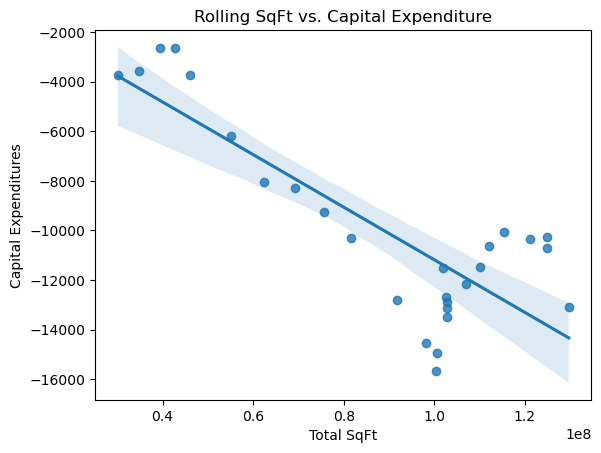

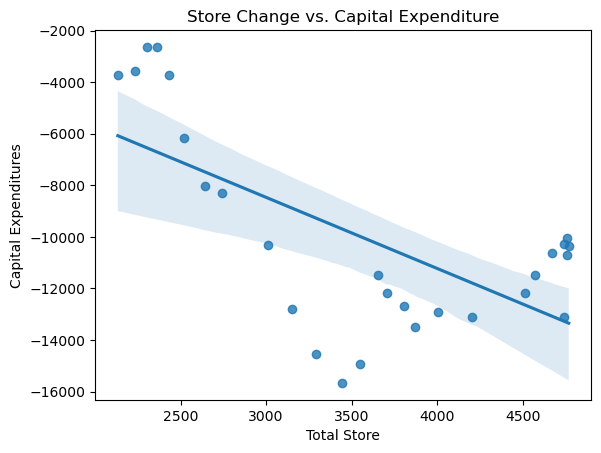

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the relationship between Capex and Rolling SqFt
sns.regplot(x='Total SqFt', y='Capital Expenditures', data=merge_data_left)
plt.title('Rolling SqFt vs. Capital Expenditure')
plt.show()

sns.regplot(x='Total Store', y='Capital Expenditures', data=merge_data_left)
plt.title('Store Change vs. Capital Expenditure')
plt.show()



In [34]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'data' is your DataFrame
# Convert all columns to numeric, setting errors='coerce' will convert non-convertible types to NaN



merge_left_numeric = merge_data_left.apply(pd.to_numeric, errors='coerce')

merge_left_numeric.index = pd.to_datetime(merge_left_numeric.index, format='%Y', errors='coerce')
merge_left_numeric.interpolate(method='linear', fill_value="extrapolate", limit_direction="both",inplace=True)
merge_left_numeric.isna().any(axis='columns')


# merge_inner_select = merge_inner_numeric[['Capital Expenditures', 'Net Income', 'Total Store', 'Total SqFt Thousands']]
merge_left_select = merge_left_numeric[['Capital Expenditures', 'Net Income', 'Total Store', 'Total SqFt Thousands']]
full_store_dist = merge_left_numeric[['Neighborhood markets', 'Discount stores', 'Supercenters', 'Total Store', 'Total SqFt Thousands']]

merge_left_select.index = pd.to_datetime(merge_left_select.index, format='%Y', errors='coerce')
merge_left_select.interpolate(method='linear', fill_value="extrapolate", limit_direction="both",inplace=True)
merge_left_select.isna().any(axis='columns')

# Check your data
merge_left_select
full_store_dist

/var/folders/dx/h3p_55411w75zkwtmc1941gr0000gn/T/ipykernel_25067/2533483997.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_left_select.interpolate(method='linear', fill_value="extrapolate", limit_direction="both",inplace=True)


,Neighborhood markets,Discount stores,Supercenters,Total Store,Total SqFt Thousands
Year,,,,,
1995-01-01,19.0,1990.0,143.0,2133.0,30126.089000
1996-01-01,19.0,1995.0,239.0,2234.0,34873.806000
1997-01-01,19.0,1960.0,344.0,2304.0,39493.206000
1998-01-01,19.0,1921.0,441.0,2362.0,42698.206000
1999-01-01,19.0,1869.0,564.0,2433.0,46145.837000
2000-01-01,19.0,1801.0,721.0,2522.0,55106.097000
2001-01-01,19.0,1736.0,888.0,2643.0,62426.741000
2002-01-01,31.0,1647.0,1066.0,2744.0,69164.741000
2003-01-01,47.5,1562.5,1268.5,2878.5,75709.759000


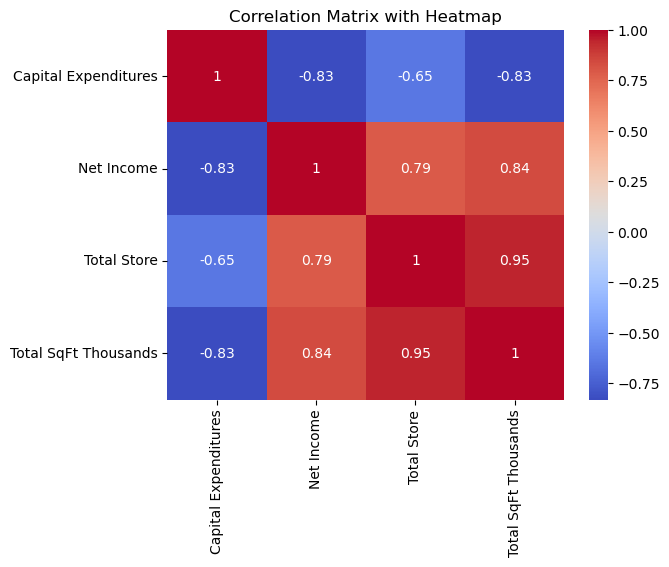

                feature         VIF
0  Capital Expenditures   37.381731
1            Net Income   22.900167
2           Total Store   93.797204
3  Total SqFt Thousands  174.963648


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def analyze_correlations(variateDFT):
    # Creating a correlation matrix and displaying it as a heatmap
    corr_matrix = variateDFT.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix with Heatmap')
    plt.show()

    # Checking for multicollinearity using Variance Inflation Factor (VIF)
    vif_data = pd.DataFrame()
    vif_data["feature"] = variateDFT.columns
    vif_data["VIF"] = [variance_inflation_factor(variateDFT.values, i) for i in range(len(variateDFT.columns))]
    print(vif_data)


analyze_correlations(merge_left_select)   


In [40]:

# df=variateDFT
# # Assuming 'df' contains your data with columns 'Year', 'Net_Income', and 'Capex'
# X = sm.add_constant(df['Net Income'])  # Adds a constant term to the predictor
# y = df['Capital Expenditures']

# model = sm.OLS(y, X).fit()
# df['Capex_Residual'] = model.resid  # Calculate and store residuals

# # Review model summary to validate the linear relationship
# print(model.summary())

import pandas as pd
import statsmodels.api as sm

def analyze_capex_relationship(data, net_income_col, capex_col):
    # Add a constant term to the predictor for the linear regression model
    #X = sm.add_constant(data[net_income_col])
    X = data[net_income_col]
    y = data[capex_col]

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()
    
    # Calculate and store residuals in the DataFrame
    data['Capex Residual '+net_income_col] = model.resid

    # Print the summary of the model to review the linear relationship
    print(model.summary())

    return data


analyze_capex_relationship(merge_left_select, 'Net Income', 'Capital Expenditures')
analyze_capex_relationship(merge_left_select, 'Total Store', 'Capital Expenditures')
analyze_capex_relationship(merge_left_select, 'Total SqFt Thousands', 'Capital Expenditures')


import pandas as pd
import statsmodels.api as sm

def perform_ols_regression(data, predictors, response):
    """
    Performs a multivariable OLS regression.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the dataset.
    - predictors (list of str): The names of the predictor columns.
    - response (str): The name of the response column.

    Returns:
    - model_summary (str): A summary of the regression model.
    """
    # Selecting predictors and adding a constant for the intercept
    X = data[predictors]
    #X = sm.add_constant(X)

    # Selecting the response variable
    y = data[response]

    # Creating and fitting the OLS model
    model = sm.OLS(y, X).fit()

    # Returning the summary of the model
    return model

model1= perform_ols_regression(merge_left_numeric,['Total SqFt Thousands'], 'Capital Expenditures')
model2= perform_ols_regression(merge_left_numeric,['Discount stores','Supercenters','Neighborhood markets','Capital Expenditures'], 'Total SqFt Thousands')

#merge_left_select[['Capital Expenditures']]

                                  OLS Regression Results                                 
Dep. Variable:     Capital Expenditures   R-squared (uncentered):                   0.947
Model:                              OLS   Adj. R-squared (uncentered):              0.945
Method:                   Least Squares   F-statistic:                              480.9
Date:                  Thu, 02 May 2024   Prob (F-statistic):                    9.74e-19
Time:                          13:01:48   Log-Likelihood:                         -258.48
No. Observations:                    28   AIC:                                      519.0
Df Residuals:                        27   BIC:                                      520.3
Df Model:                             1                                                  
Covariance Type:              nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

/var/folders/dx/h3p_55411w75zkwtmc1941gr0000gn/T/ipykernel_25067/470180023.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Capex Residual '+net_income_col] = model.resid
/var/folders/dx/h3p_55411w75zkwtmc1941gr0000gn/T/ipykernel_25067/470180023.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Capex Residual '+net_income_col] = model.resid
/var/folders/dx/h3p_55411w75zkwtmc1941gr0000gn/T/ipykernel_25067/470180023.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Capital Expenditures   R-squared (uncentered):                   0.989
Model:                              OLS   Adj. R-squared (uncentered):              0.987
Method:                   Least Squares   F-statistic:                              429.5
Date:                  Thu, 02 May 2024   Prob (F-statistic):                    6.57e-22
Time:                          13:01:48   Log-Likelihood:                         -235.90
No. Observations:                    28   AIC:                                      481.8
Df Residuals:                        23   BIC:                                      488.5
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Net Income              -0.1234      0.154     -0.801      0.432      -0.442       0.195
Discount stores          1.4374      0.655      2.195      0.038       0.083       2.792
Supercenters             0.8232      1.674      0.492      0.628      -2.640       4.287
Neighborhood markets     8.4667      2.285      3.705      0.001       3.739      13.194
Total SqFt Thousands    -0.1634      0.034     -4.864      0.000      -0.233      -0.094
==============================================================================
Omnibus:                        0.821   Durbin-Watson:                   0.927
Prob(Omnibus):                  0.663   Jarque-Bera (JB):                0.735
Skew:                           0.005   Prob(JB):                        0.693
Kurtosis:                       2.206   Cond. No.                     1.11e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
# def analyze_capex_store_relationship(financial_data, store_counts):
#     # Extracting CapEx data and the relevant years
#     capex_data = financial_data[financial_data['Cash Metric'].isin(['Purchase of Fixed Assets', 'Capital Expenditures'])]
#     print(f"Before transposition: {capex_data.shape}")  # Check the shape before transposition
#     print(capex_data)  # View the content
    
#     capex_data = capex_data.drop('Cash Metric', axis=1).transpose()  # Transpose to make the years as rows
#     print(f"After transposition: {capex_data.shape}")  # Check the shape after transposition
#     print(capex_data)  # View the content
    
#     # Ensure that we have exactly two rows for 'Purchase of Fixed Assets' and 'Capital Expenditures'
#     if capex_data.shape[0] == 2:
#         capex_data.columns = ['Purchase of Fixed Assets', 'Capital Expenditures']
#     else:
#         raise ValueError("The CapEx data does not have the expected number of rows after transposition.")
    
#     # ... rest of the original function ...
    
#     return capex_data  # Temporarily return this to check the output

# # Call the function with the data
# capex_data_checked = analyze_capex_store_relationship(cashflow_data, store_count)


In [36]:
# import pandas as pd


# def preprocess_store_counts(store_counts):
#     # Ensure all data is numeric, converting non-numeric to NaN
#     store_counts = store_counts.apply(pd.to_numeric, errors='coerce')

#     # Calculate net change in stores per year for each type of store
#     store_counts_diff = store_counts.diff(axis=1)  # Calculate year-over-year difference
#     store_counts_diff = store_counts_diff.iloc[:, 1:]  # Exclude the first column as it will be NaN after diff
    
#     return store_counts_diff

# # Re-run the preprocessing with corrected data types
# # store_counts_diff = preprocess_store_counts(store_count)

# # Optionally, you can check if there are many NaNs, which might indicate many non-numeric entries
# # print(store_counts_diff.isna().sum())

# def correlate_capex_changes(store_counts_diff, financial_data):
#     # Focus on Capital Expenditures for simplicity
#     capex_data = financial_data.loc[financial_data['Cash Metric'].isin(['Capital Expenditures'])]
#     capex_data = capex_data.drop('Cash Metric', axis=1).transpose()
#     capex_data.columns = ['Capital Expenditures']  # Set proper column name after transpose

#     # Ensure data types are correct for analysis
#     capex_data = capex_data.astype(float)  # Convert CapEx data to float for calculations
#     store_counts_diff = store_counts_diff.astype(float)  # Also ensure store count diffs are float

#     # Align the indices of both DataFrames to ensure they match for correlation analysis
#     # Both should have years as indices and be aligned accordingly
#     if not capex_data.index.equals(store_counts_diff.columns):
#         # Assuming both indices are years and formatted similarly
#         # This step might need adjustment based on actual index formats
#         capex_data = capex_data.reindex(store_counts_diff.columns)
#         print(store_counts_diff)
#         store_counts_diff=store_counts_diff.T
#         store_counts_diff=store_counts_diff.shift(periods=-1)
#         store_counts_diff=store_counts_diff.T
#         print(store_counts_diff)
#     # Compute correlation matrix
#     correlation_matrix = pd.concat([capex_data.iloc[::-1], store_counts_diff.loc[3]], axis=1).corr()
#     print(capex_data)
#     return correlation_matrix

# # Assuming 'cashflow_data' and 'store_count' are your DataFrames loaded correctly
# store_counts_diff = preprocess_store_counts(store_count)

# correlation_results = correlate_capex_changes(store_counts_diff, cashflow_data)

# # Output results
# print(correlation_results)
# store_count_total=store_count.loc[3]

   2012   2013   2014   2015  2016  2017  2018  2019  2020  2021  ...   2005  \
0   NaN  129.0  130.0  119.0  58.0  57.0  39.0   9.0   1.0  -1.0  ... -267.0   
1   NaN   76.0  121.0  232.0  28.0  68.0  65.0  13.0  -4.0 -10.0  ...  -15.0   
2   NaN  -68.0  -53.0  -38.0 -28.0 -27.0 -15.0 -14.0 -10.0  -2.0  ...  144.0   
3   NaN  137.0  198.0  313.0  58.0  98.0  89.0   8.0 -13.0 -13.0  ... -138.0   

    2004   2002   2001   2000   1999   1998  1997   1996   1995  
0 -242.0 -405.0 -178.0 -167.0 -157.0 -123.0 -97.0 -105.0  -96.0  
1  -21.0  -33.0  -12.0    NaN    NaN    NaN   NaN    NaN    NaN  
2  125.0  169.0   89.0   65.0   68.0   52.0  39.0   35.0   -5.0  
3 -138.0 -269.0 -101.0 -121.0  -89.0  -71.0 -58.0  -70.0 -101.0  

[4 rows x 27 columns]
    2012   2013   2014  2015  2016  2017  2018  2019  2020  2021  ...   2005  \
0  129.0  130.0  119.0  58.0  57.0  39.0   9.0   1.0  -1.0   3.0  ... -242.0   
1   76.0  121.0  232.0  28.0  68.0  65.0  13.0  -4.0 -10.0   0.0  ...  -21.0   
2  -68

In [ ]:

# # def correlate_capex_changes(store_counts_diff, financial_data):
# #     # Focus on Capital Expenditures for simplicity
# capex_data = cashflow_data.loc[cashflow_data['Cash Metric'].isin(['Capital Expenditures'])]
# capex_data = capex_data.drop('Cash Metric', axis=1).transpose()
# capex_data.columns = ['Capital Expenditures']  # Set proper column name after transpose
# capex_data.index
# print(capex_data)
# dist_counts_diff = preprocess_store_counts(totaldist_count.T)
# dist_counts_diffT=dist_counts_diff.T
# dist_counts_diffT=dist_counts_diffT.shift(periods=-5)
# dist_counts_diffT.index=dist_counts_diffT.index.astype('string')
# print(dist_counts_diffT)


# dist_counts_diffT = dist_counts_diffT.loc[dist_counts_diffT.index.isin(capex_data.index)]
# #dist_counts_diffT
# correlation_matrix = pd.concat([capex_data, dist_counts_diffT], axis=1).corr()
# correlation_matrix


#     # # Ensure data types are correct for analysis
#     # capex_data = capex_data.astype(float)  # Convert CapEx data to float for calculations
#     # store_counts_diff = store_counts_diff.astype(float)  # Also ensure store count diffs are float

#     # # Align the indices of both DataFrames to ensure they match for correlation analysis
#     # # Both should have years as indices and be aligned accordingly
#     # if not capex_data.index.equals(store_counts_diff.columns):
#     #     # Assuming both indices are years and formatted similarly
#     #     # This step might need adjustment based on actual index formats
#     #     #capex_data = capex_data.reindex(store_counts_diff.columns)
#     #     store_counts_diff=store_counts_diff.loc[store_counts['Cash Metric'].isin(['Capital Expenditures'])]
#     #     store_counts_diff=store_counts_diff.reindex(capex_data.index)
#     #     store_counts_diff=store_counts_diff.T
#     #     #print(store_counts_diff)
#     # # Compute correlation matrix
#     # correlation_matrix = pd.concat([capex_data, store_counts_diff], axis=1).corr()
#     # return correlation_matrix

# # Assuming 'cashflow_data' and 'store_count' are your DataFrames loaded correctly

# # correlation_results = correlate_capex_changes(dist_counts_diff, cashflow_data)

# # Output results
# #print(correlation_results)


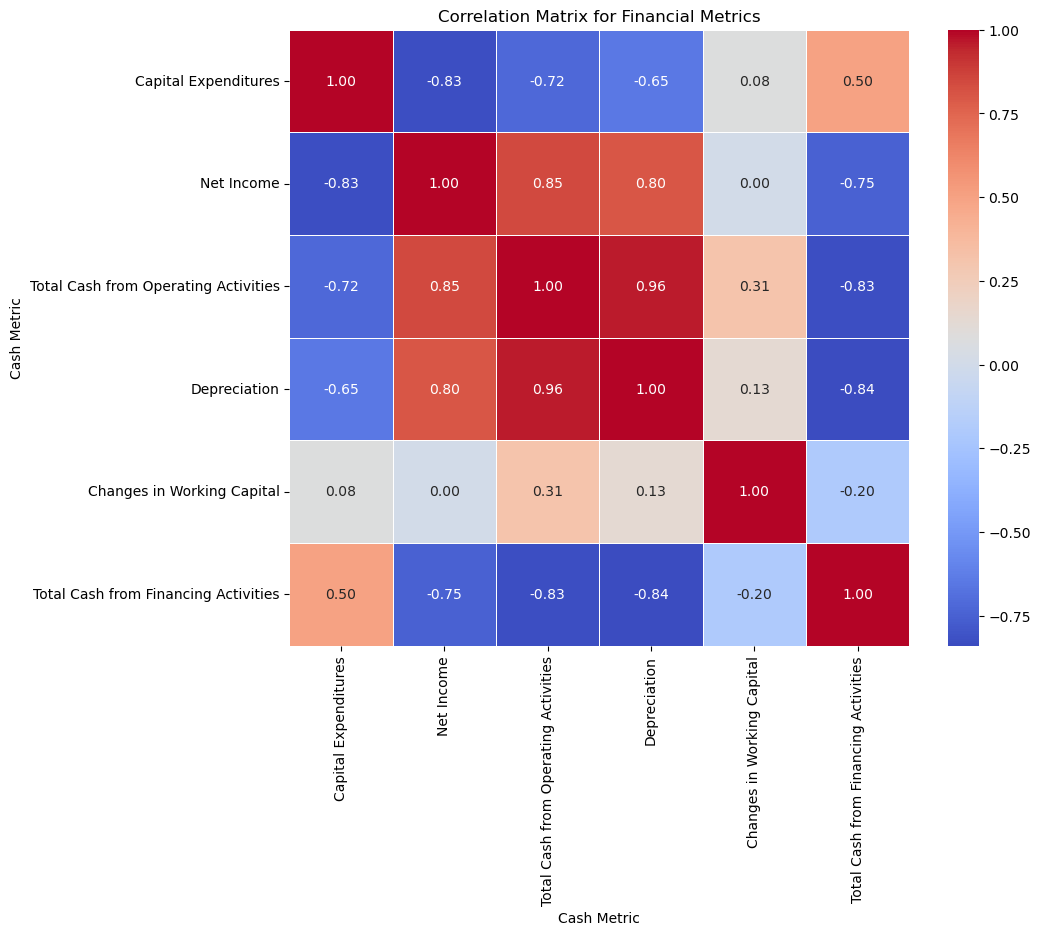

Cash Metric                           Capital Expenditures  Net Income  \
Cash Metric                                                              
Capital Expenditures                              1.000000   -0.831369   
Net Income                                       -0.831369    1.000000   
Total Cash from Operating Activities             -0.723536    0.848533   
Depreciation                                     -0.646048    0.801412   
Changes in Working Capital                        0.077055    0.003467   
Total Cash from Financing Activities              0.502499   -0.749734   

Cash Metric                           Total Cash from Operating Activities  \
Cash Metric                                                                  
Capital Expenditures                                             -0.723536   
Net Income                                                        0.848533   
Total Cash from Operating Activities                              1.000000   
Depreciation     

In [15]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# def expanded_correlation_analysis(financial_data, metrics_list):
#     # Filter for relevant metrics
#     relevant_data = financial_data[metrics_list]
#     # Calculate correlations
#     correlation_matrix = relevant_data.corr()
    
#     # Plot the correlation matrix
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
#     plt.title('Correlation Matrix for Financial Metrics')
#     plt.show()

#     return correlation_matrix

# # Define the list of metrics to include in the analysis
# metrics_to_analyze = [
#     'Capital Expenditures',
#     'Net Income',
#     'Total Cash from Operating Activities',
#     'Depreciation',
#     'Changes in Working Capital',
#     'Total Cash from Financing Activities'
# ]

# if cashflow_data.index.name != 'Cash Metric':
#     cashflow_datacopy=cashflow_data.copy
#     cashflow_data.set_index('Cash Metric', inplace=True)  # Setting 'Cash Metric' as index

# cashflow_dataT=cashflow_data.T
# cashflow_dataT.columns
# # cashflow_dataT['Net Income']

# # Assuming 'cashflow_data' is your DataFrame containing all financial metrics
# correlation_results = expanded_correlation_analysis(cashflow_dataT, metrics_to_analyze)
# print(correlation_results)



In [ ]:

# def analyze_capex_store_relationship(financial_data, store_counts):
#     # Analyze the relationship between CapEx and store counts
#     # ...

# def model_capex_for_new_stores(financial_data, store_counts):
#     # Model CapEx for new stores using regression analysis or curve fitting
#     # ...

# def monte_carlo_simulation(model):
#     # Perform Monte Carlo simulation using the CapEx model
#     # ...

# def integrate_with_expansion_model(expansion_model, capex_model):
#     # Update NeighborhoodMarketExpansionModel with new CapEx estimates
#     # ...

# # Now let's run these functions in sequence

# preprocessed_financial_data = preprocess_data(financial_data, store_counts)
# capex_store_relationship = analyze_capex_store_relationship(preprocessed_financial_data, store_counts)
# capex_model = model_capex_for_new_stores(preprocessed_financial_data, store_counts)
# simulation_results = monte_carlo_simulation(capex_model)
# integrate_with_expansion_model(neighborhood_market_expansion_model, capex_model)


## Distribution Center Correlation

In [37]:
# import pandas as pd

# # Assuming 'distribution_center_data' is loaded into a DataFrame with a 'Total' column already calculated
# def preprocess_distribution_totals(distribution_center_data):
#     # Calculate year-over-year changes for the total count of distribution centers
#     distribution_diff = distribution_center_data['Total'].diff().dropna()  # Calculate and drop the first NaN result
#     return distribution_diff

# def correlate_distribution_totals_capex(distribution_diff, capex_data):
#     # Ensure capex_data is aligned and formatted correctly, focusing on 'Capital Expenditures'
#     capex_data = capex_data.loc[capex_data['Cash Metric'] == 'Capital Expenditures'].drop('Cash Metric', axis=1)
#     capex_data = capex_data.transpose()
#     capex_data.columns = ['CapEx']
    
#     # Ensure the years align between both datasets
#     common_years = distribution_diff.index.intersection(capex_data.index)
#     distribution_aligned = distribution_diff.loc[common_years]
#     capex_aligned = capex_data.loc[common_years]
    
#     # Compute correlation
#     correlation_result = distribution_aligned.corr(capex_aligned['CapEx'])
#     return correlation_result

# # Load your distribution center data and cash flow data correctly before calling these functions
# distribution_diff = preprocess_distribution_totals(distribution_center_data)
# correlation_result = correlate_distribution_totals_capex(distribution_diff, cashflow_data)

# # Print or visualize the result
# print("Correlation between total distribution center changes and CapEx:", correlation_result)


NameError: name 'distribution_center_data' is not defined

## Some Visual Trash

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats
# from sklearn.linear_model import LinearRegression

# # Analyzing the relationship between CapEx and store counts
# def analyze_capex_store_relationship(financial_data, store_counts):
#     # Here you can calculate correlations and perform regression analysis
#     # This is a placeholder for the real implementation
#     correlation = financial_data.corrwith(store_counts)
#     print("Correlation between CapEx and store counts:", correlation)
    
#     # For visualization, you could plot CapEx vs store counts
#     plt.scatter(store_counts, financial_data['Capital Expenditures'])
#     plt.xlabel('Store Counts')
#     plt.ylabel('Capital Expenditures')
#     plt.show()

# # Modeling CapEx for new stores using regression analysis
# def model_capex_for_new_stores(financial_data, store_counts):
#     # Prepare the data
#     X = store_counts.values.reshape(-1, 1)  # Features
#     y = financial_data['Capital Expenditures'].values      # Target variable
    
#     # Fit the linear regression model
#     model = LinearRegression()
#     model.fit(X, y)
    
#     return model

# # Performing Monte Carlo simulation using the CapEx model
# def monte_carlo_simulation(model, n_simulations=1000):
#     # Placeholder for real implementation
#     # Simulate different scenarios to project future CapEx
#     simulations = []
#     for _ in range(n_simulations):
#         simulated_store_count = np.random.normal(loc=store_count_mean, scale=store_count_std)
#         projected_capex = model.predict([[simulated_store_count]])
#         simulations.append(projected_capex)
    
#     return np.mean(simulations), np.std(simulations)

# # Assuming financial_data and store_counts DataFrames are already preprocessed and loaded
# capex_model = model_capex_for_new_stores(cashflow_data, store_count)
# mean_projection, std_deviation = monte_carlo_simulation(capex_model)
# print(f"Projected CapEx Mean: {mean_projection}, Standard Deviation: {std_deviation}")
